In [2]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


In [3]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
M = L2Space(10, function_domain) # model space
N_d = 50 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

In [4]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=200)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=200)

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


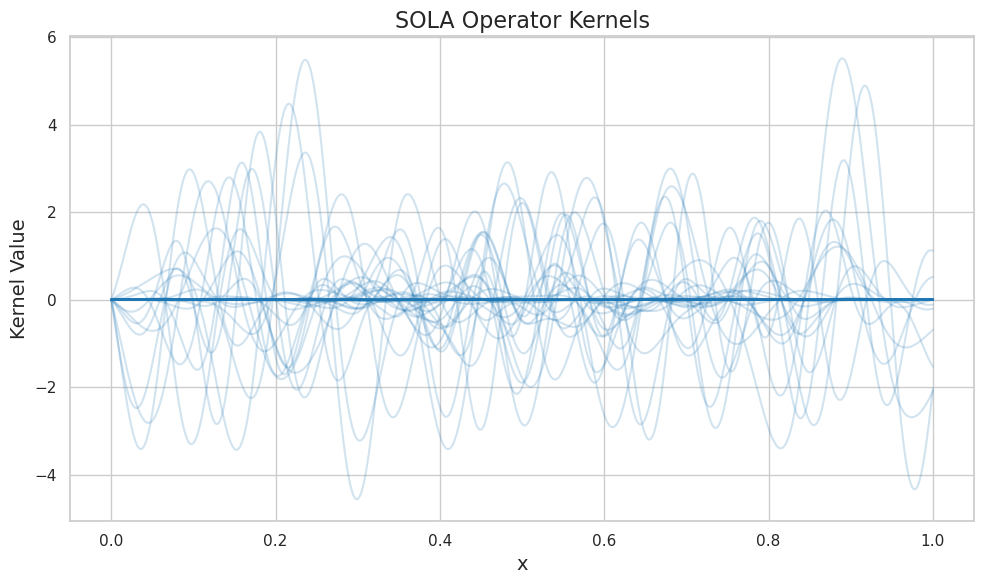

In [5]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))
for i in range(N_d):
    plt.plot(x, G.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.2)
plt.title('SOLA Operator Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

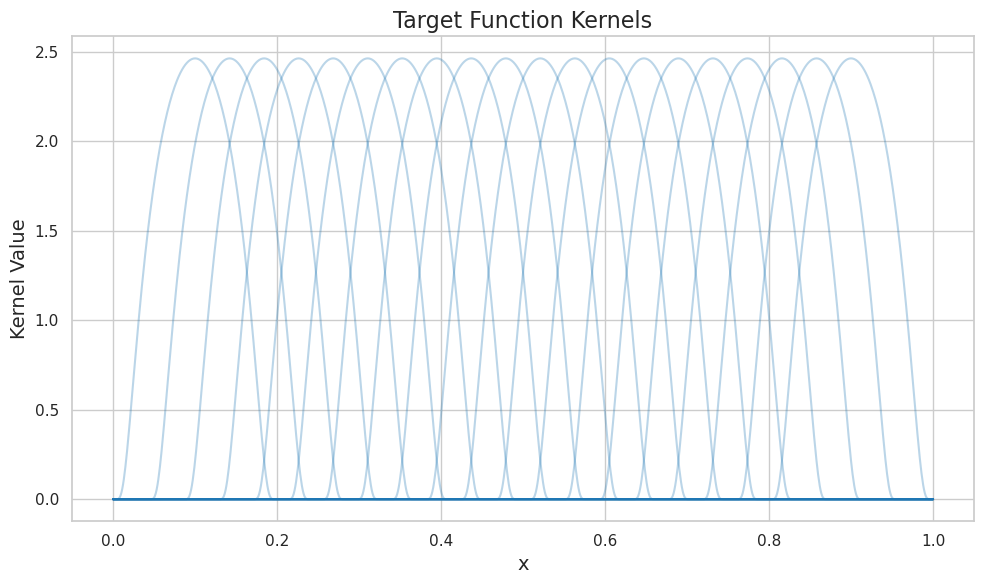

In [6]:
plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, T.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('Target Function Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

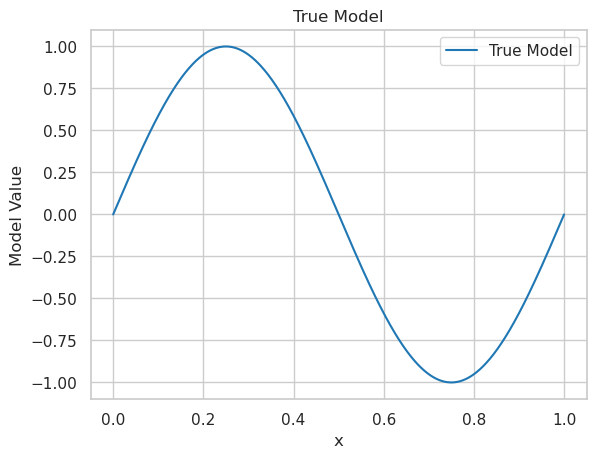

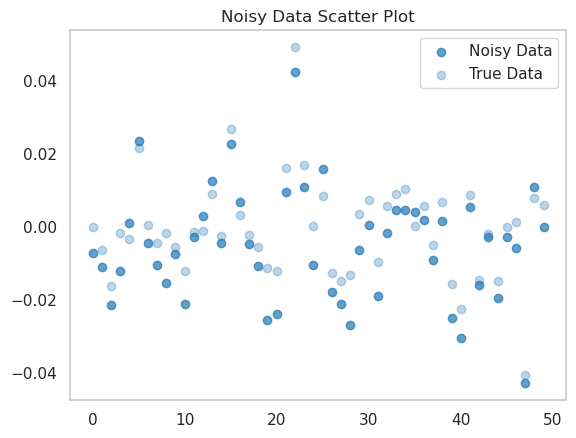

In [7]:
# Create a true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
# Plot the true model
plt.plot(x, m_bar.evaluate(x), label='True Model', color='tab:blue')
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.show()

# Create corresponding data
d_bar = G(m_bar)
# Create noisy data
d_tilde = d_bar + np.random.normal(-0.1*np.max(d_bar), 0.1*np.max(d_bar), d_bar.shape)

plt.scatter(np.arange(len(d_bar)), d_tilde, label='Noisy Data', color='tab:blue', alpha=0.7)
plt.scatter(np.arange(len(d_bar)), d_bar, label='True Data', color='tab:blue', alpha=0.3)
plt.grid()
plt.title('Noisy Data Scatter Plot')
plt.legend()
plt.show()

In [8]:
# Compute normal operator
Lambda = LinearOperator.from_matrix(D, D, G.compute_gram_matrix())
cholesky_solver = CholeskySolver(galerkin=True)
Lambda_inv = cholesky_solver(Lambda)
G_inv = G.adjoint @ Lambda_inv

In [9]:
# Compute both the solution from the true data and the noisy data
m_tilde = G_inv(d_bar)
m_tilde_noisy = G_inv(d_tilde)

The noisy reconstruction diverges

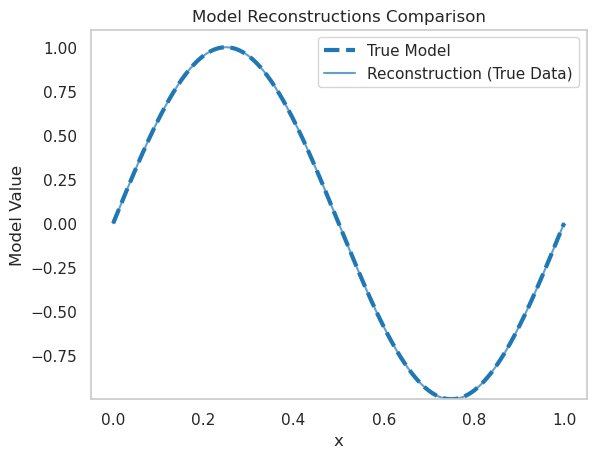

In [10]:
# Toggle to show/hide noisy reconstruction
show_noisy_reconstruction = False  # Set to True to show, False to hide
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--', color='tab:blue', linewidth=3)
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (True Data)', color='tab:blue', alpha=0.7, linewidth=1.5)
if show_noisy_reconstruction:
    plt.plot(x, m_tilde_noisy.evaluate(x), label='Reconstruction (Noisy Data)', color='tab:blue', alpha=0.3, linewidth=1.5)
plt.ylim(np.max(m_bar.evaluate(x)) * -1, np.max(m_bar.evaluate(x)) * 1.1)
plt.title('Model Reconstructions Comparison')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the property values for the true model and the reconstructions
p_bar = T(m_bar)
p_tilde = T(m_tilde)
p_tilde_noisy = T(m_tilde_noisy)

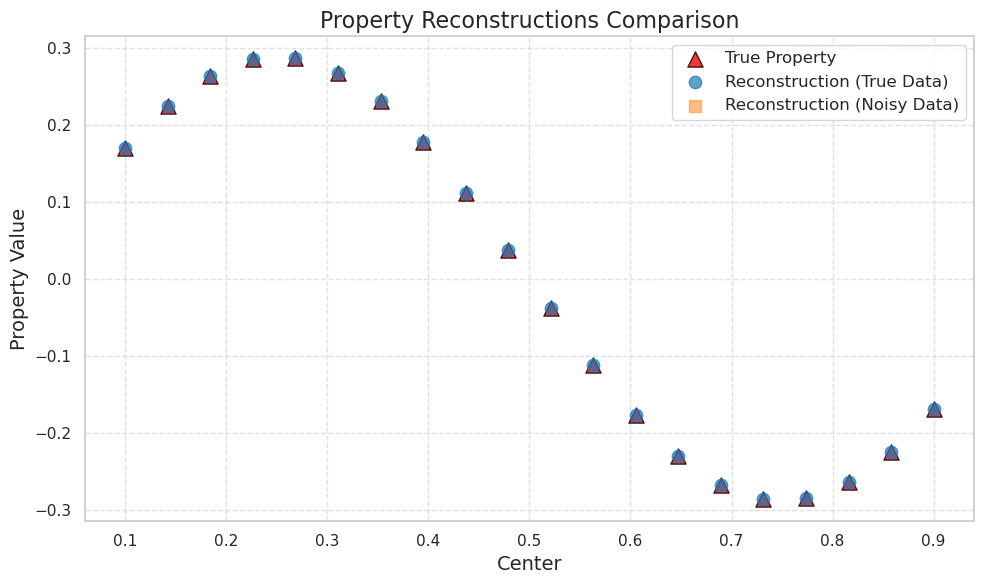

In [12]:
# Improved property reconstructions comparison figure
plt.figure(figsize=(10, 6))
plt.scatter(centers, p_bar, label='True Property', color='red', marker='^', s=120, edgecolor='black', alpha=0.8)
plt.scatter(centers, p_tilde, label='Reconstruction (True Data)', color='tab:blue', marker='o', s=80, alpha=0.7)
plt.scatter(centers, p_tilde_noisy, label='Reconstruction (Noisy Data)', color='tab:orange', marker='s', s=80, alpha=0.5)
plt.ylim(np.max(p_bar) * -1.1, np.max(p_bar) * 1.1)
plt.title('Property Reconstructions Comparison', fontsize=16)
plt.xlabel('Center', fontsize=14)
plt.ylabel('Property Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True)
plt.tight_layout()
plt.show()